Brandon Fan\
Brandon Kmiec\
Kyle Mucha\
Ian Vachuska

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
from sklearn import svm, datasets, preprocessing, metrics
from sklearn.model_selection import train_test_split

from collections.abc import Sequence

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Activation, Bidirectional, LSTM,
    Conv2D, Dropout, MaxPooling2D, Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
import matplotlib.pyplot as plt

# **Helper Functions**

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1, data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])
    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()
#Offset: time series entries are in past 
#Shift: time series is as normal but less rows to be compatible with concat
def to_sequences(seq_size, data, offset = 0):
    x = []
    y = []
    
    for i in range(len(data)-seq_size-1):
        #index will not be out of range
        #timeseries will be weird for the first `offset` entries
        index = max(i - offset,0)
        
        window = data[index:(index + seq_size)]
        after_window = data[i + seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)

#Ian Vachuska
def shape_data(data, inputs = 4, series_length = 7, channels = 1):
    x_fcnn = data.reshape(data.shape[0:2])
                                #-1 bc date isnt dropped in df
    x_cnn = data.reshape(data.shape[0], inputs, series_length, channels)
                                #-1 bc date isnt dropped in df
    x_rnn = data.reshape(data.shape[0], inputs*channels, series_length)
    return x_fcnn, x_cnn, x_rnn

# **Read CSV File**

In [3]:
#Brandon Kmiec

import numpy as np
import pandas as pd
import os

path = '/kaggle/input/csus-weather-data-csv/csus-weather-data.csv'
#path = '/kaggle/input/d/ianvachuska/csus-weather-data-csv/csus-weather-data.csv'

df = pd.read_csv(path, na_values=[' M'])

print("df shape: {}".format(df.shape))
df

df shape: (15340, 25)


,Date,MaxTemperature,MaxTemperatureNormal,MaxTemperatureDeparture,MinTemperature,MinTemperatureNormal,MinTemperatureDeparture,AvgTemperature,AvgTemperatureNormal,AvgTemperatureDeparture,...,SnowfallNormal,SnowfallDeparture,SnowDepth,HDD,HDDNormal,HDDDeparture,CDD,CDDNormal,CDDDeparture,GDD
0,1982-01-01,56.0,55.2,0.8,43.0,40.3,2.7,49.5,47.8,1.7,...,0.0,NaN,NaN,15.0,17.2,-2.2,0.0,0.0,0.0,0.0
1,1982-01-02,54.0,55.2,-1.2,40.0,40.4,-0.4,47.0,47.8,-0.8,...,0.0,NaN,NaN,18.0,17.2,0.8,0.0,0.0,0.0,0.0
2,1982-01-03,47.0,55.2,-8.2,37.0,40.4,-3.4,42.0,47.8,-5.8,...,0.0,NaN,NaN,23.0,17.2,5.8,0.0,0.0,0.0,0.0
3,1982-01-04,50.0,55.3,-5.3,42.0,40.4,1.6,46.0,47.8,-1.8,...,0.0,NaN,NaN,19.0,17.2,1.8,0.0,0.0,0.0,0.0
4,1982-01-05,50.0,55.3,-5.3,40.0,40.5,-0.5,45.0,47.9,-2.9,...,0.0,NaN,NaN,20.0,17.1,2.9,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15335,2023-12-27,60.0,55.2,4.8,45.0,40.2,4.8,52.5,47.7,4.8,...,0.0,0.0,NaN,12.0,17.3,-5.3,0.0,0.0,0.0,3.0
15336,2023-12-28,66.0,55.2,10.8,48.0,40.2,7.8,57.0,47.7,9.3,...,0.0,0.0,NaN,8.0,17.3,-9.3,0.0,0.0,0.0,7.0
15337,2023-12-29,66.0,55.2,10.8,49.0,40.3,8.7,57.5,47.7,9.8,...,0.0,0.0,NaN,7.0,17.3,-10.3,0.0,0.0,0.0,8.0
15338,2023-12-30,63.0,55.2,7.8,51.0,40.3,10.7,57.0,47.7,9.3,...,0.0,0.0,NaN,8.0,17.3,-9.3,0.0,0.0,0.0,7.0


# **Drop Unneeded Columns**

In [4]:
#Brandon Kmiec

# Remove whitespace infront of column names
cols = df.columns
for i in range(df.shape[1]):
    df.rename(columns={cols[i]:cols[i].strip()}, inplace=True)

In [5]:
#Brandon Kmiec

df.drop(['Date'], axis=1, inplace=True)
df.drop(['MaxTemperatureNormal', 'MaxTemperatureDeparture'], axis=1, inplace=True)
df.drop(['MinTemperatureNormal', 'MinTemperatureDeparture'], axis=1, inplace=True)
df.drop(['AvgTemperatureNormal', 'AvgTemperatureDeparture'], axis=1, inplace=True)
df.drop(['AtObsTemperature'], axis=1, inplace=True)
df.drop(['PrecipitationNormal', 'PrecipitationDeparture'], axis=1, inplace=True)
df.drop(['Snowfall', 'SnowfallNormal', 'SnowfallDeparture', 'SnowDepth'], axis=1, inplace=True)
df.drop(['HDD', 'HDDNormal', 'HDDDeparture'], axis=1, inplace=True)
df.drop(['CDD', 'CDDNormal', 'CDDDeparture'], axis=1, inplace=True)
df.drop(['GDD'], axis=1, inplace=True)

print("df shape: {}".format(df.shape))
df

df shape: (15340, 4)


,MaxTemperature,MinTemperature,AvgTemperature,Precipitation
0,56.0,43.0,49.5,0.39
1,54.0,40.0,47.0,0.00
2,47.0,37.0,42.0,0.35
3,50.0,42.0,46.0,3.10
4,50.0,40.0,45.0,0.55
...,...,...,...,...
15335,60.0,45.0,52.5,0.34
15336,66.0,48.0,57.0,0.00
15337,66.0,49.0,57.5,0.63
15338,63.0,51.0,57.0,0.29


# **Normalize Data**

In [6]:
#Brandon Kmiec

# Verify replacing missing values with mean of previous and next value and converting type to np.float64

# Missing value in MaxTemperature on 4/30/1999 and 12/16/2006
# Missing value in MinTemperature on 12/15/2006
# Missing value in AvgTemperature on 4/30/1999, 12/15/2006, and 12/16/2006

#print("{}\n".format(df.dtypes))

print(df.iloc[9115])

# Replace NaN with average of previous and next value
# (taking the mean of entire column not recommended for time series data)
for column in df.columns:
    col = df.columns.get_loc(column)
    for row in range(df.shape[0]):
        if pd.isna(df.iloc[row, col]):
            print("\nNot a Number")
            prev_val = df.iloc[row - 1, col] if row > 0 else df.iloc[row + 1, col]
            next_val = df.iloc[row + 1, col] if row < len(df) - 1 else df.iloc[row - 1, col]
            
            if pd.isna(prev_val):
                pre_val = df.iloc[row - 2, col]
            if pd.isna(next_val):
                next_val = df.iloc[row + 2, col]
                
            df.iloc[row, col] = (prev_val + next_val) / 2
            print(f"Change pos [{row}, {col}] to {df.iloc[row, col]}. prev: {prev_val}, next: {next_val}")


# old code to replace NaN with mean of entire column
'''
#df['MaxTemperature'].fillna(df['MaxTemperature'].mean())
df['MaxTemperature'] = df['MaxTemperature'].replace(np.NaN, round(df['MaxTemperature'].mean(), 2))
#df['MinTemperature'].fillna(df['MinTemperature'].mean())
df['MinTemperature'] = df['MinTemperature'].replace(np.NaN, round(df['MinTemperature'].mean(), 2))
#df['AvgTemperature'].fillna(df['AvgTemperature'].mean())
df['AvgTemperature'] = df['AvgTemperature'].replace(np.NaN, round(df['AvgTemperature'].mean(), 2))
'''

#df['Date'] = pd.to_numeric(pd.to_datetime(df['Date']))
df['MaxTemperature'] = df['MaxTemperature'].astype(np.float64)
df['MinTemperature'] = df['MinTemperature'].astype(np.float64)
df['AvgTemperature'] = df['AvgTemperature'].astype(np.float64)

print("\n{}".format(df.iloc[9115]))

print("\n{}\n".format(df.dtypes))

MaxTemperature     NaN
MinTemperature    35.0
AvgTemperature     NaN
Precipitation      0.0
Name: 9115, dtype: float64

Not a Number
Change pos [6328, 0] to 77.0. prev: 78.0, next: 76.0

Not a Number
Change pos [9115, 0] to 55.0. prev: 58.0, next: 52.0

Not a Number
Change pos [9114, 1] to 46.0. prev: 57.0, next: 35.0

Not a Number
Change pos [6328, 2] to 63.75. prev: 64.5, next: 63.0

Not a Number
Change pos [9114, 2] to 51.5. prev: 60.5, next: 42.5

Not a Number
Change pos [9115, 2] to 47.0. prev: 51.5, next: 42.5

MaxTemperature    55.0
MinTemperature    35.0
AvgTemperature    47.0
Precipitation      0.0
Name: 9115, dtype: float64

MaxTemperature    float64
MinTemperature    float64
AvgTemperature    float64
Precipitation     float64
dtype: object



In [7]:
#Ian Vachuska
#copy output layer before z-score encoding(outputlayer should never be normalized)
output_df = df.copy()

In [8]:
#Brandon Kmiec

encode_numeric_zscore(df, 'MaxTemperature')
encode_numeric_zscore(df, 'MinTemperature')
encode_numeric_zscore(df, 'AvgTemperature')
encode_numeric_zscore(df, 'Precipitation')


print("df shape: {}".format(df.shape))
print("precip_out shape: {}".format(df.shape))
df

df shape: (15340, 4)
precip_out shape: (15340, 4)


,MaxTemperature,MinTemperature,AvgTemperature,Precipitation
0,-1.276356,-0.926882,-1.187127,1.650350
1,-1.403963,-1.259603,-1.396409,-0.259462
2,-1.850590,-1.592324,-1.814972,1.454472
3,-1.659179,-1.037789,-1.480121,14.921098
4,-1.659179,-1.259603,-1.563834,2.433863
...,...,...,...,...
15335,-1.021140,-0.705069,-0.935988,1.405503
15336,-0.638317,-0.372348,-0.559281,-0.259462
15337,-0.638317,-0.261441,-0.517424,2.825620
15338,-0.829729,-0.039627,-0.559281,1.160655


In [9]:
#Ian Vachuska
TEST_SIZE = .3
RANDOM_STATE = 42
x, y = to_xy(df, 'Precipitation')
x_train, x_test, ya_train, ya_test = train_test_split(
    x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print("x:\ntrain {}\ntest  {}".format(x_train.shape, x_test.shape))
print("y:\ntrain {}\ntest  {}".format(ya_train.shape, ya_test.shape))

x:
train (10738, 3)
test  (4602, 3)
y:
train (10738,)
test  (4602,)


<h1>Create Time Series</h1>

In [10]:
#Ian Vachuska
#SEQUENCE_SIZE is equal to the length of the time series
SEQUENCE_SIZE = 28
#SEQUENCE_OFFSET is equal to the additional days in the past
SEQUENCE_OFFSET = 365
#One for this year(ty) and one for last year(ly)
CHANNELS = 2
#dont use z, its a dummy variable

# input series LAST YEAR
max_temp_ly_np, z = to_sequences(SEQUENCE_SIZE,df['MaxTemperature'].tolist(),SEQUENCE_OFFSET)
min_temp_ly_np, z = to_sequences(SEQUENCE_SIZE,df['MinTemperature'].tolist(),SEQUENCE_OFFSET)
avg_temp_ly_np, z = to_sequences(SEQUENCE_SIZE,df['AvgTemperature'].tolist(),SEQUENCE_OFFSET)
precip_ly_np, z   = to_sequences(SEQUENCE_SIZE,df['Precipitation'].tolist(),SEQUENCE_OFFSET)

# input series
max_temp_ty_np, z = to_sequences(SEQUENCE_SIZE,df['MaxTemperature'].tolist())
min_temp_ty_np, z = to_sequences(SEQUENCE_SIZE,df['MinTemperature'].tolist())
avg_temp_ty_np, z = to_sequences(SEQUENCE_SIZE,df['AvgTemperature'].tolist())
precip_ty_np, z   = to_sequences(SEQUENCE_SIZE,df['Precipitation'].tolist())

x_ly = np.concatenate((max_temp_ly_np, min_temp_ly_np, avg_temp_ly_np, precip_ly_np), axis=1)
x_ty = np.concatenate((max_temp_ty_np, min_temp_ty_np, avg_temp_ty_np, precip_ty_np), axis=1)

# output value array (Not Normalized)
#-----------------------------------------<v---------------------v>-------
output_layer = 'Precipitation'
z, y = to_sequences(SEQUENCE_SIZE, output_df[output_layer].tolist())
#-----------------------------------------<^SET OUTPUT LAYER HERE^>-------

#Join ty & ly time series
x = np.concatenate((x_ty,x_ly), axis=1)
print("x_ty: {}\nx_ly: {}\n\nx: {}".format(x_ty.shape,x_ly.shape,x.shape))

x_ty: (15311, 112, 1)
x_ly: (15311, 112, 1)

x: (15311, 224, 1)


<h1>Shape Time Series Data for FCNN/CNN/RNN</h1>

In [11]:
#Ian Vachuska
#Single input layer
x_fcnn, x_cnn, x_rnn = shape_data(x, df.shape[1], SEQUENCE_SIZE, CHANNELS)
print("x_fcnn: {}".format(x_fcnn.shape))
print("x_cnn: {}".format(x_cnn.shape))
print("x_rnn: {}\n".format(x_rnn.shape))

#Multi input layer
#last year
x_fcnn_ly, x_cnn_ly, x_rnn_ly = shape_data(x_ly, df.shape[1], SEQUENCE_SIZE, 1)
print("x_fcnn_ly: {}".format(x_fcnn_ly.shape))
print("x_cnn_ly: {}".format(x_cnn_ly.shape))
print("x_rnn_ly: {}\n".format(x_rnn_ly.shape))
#this year
x_fcnn_ty, x_cnn_ty, x_rnn_ty = shape_data(x_ty, df.shape[1], SEQUENCE_SIZE, 1)
print("x_fcnn_ty: {}".format(x_fcnn_ty.shape))
print("x_cnn_ty: {}".format(x_cnn_ty.shape))
print("x_rnn_ty: {}\n".format(x_rnn_ty.shape))


x_fcnn: (15311, 224)
x_cnn: (15311, 4, 28, 2)
x_rnn: (15311, 8, 28)

x_fcnn_ly: (15311, 112)
x_cnn_ly: (15311, 4, 28, 1)
x_rnn_ly: (15311, 4, 28)

x_fcnn_ty: (15311, 112)
x_cnn_ty: (15311, 4, 28, 1)
x_rnn_ty: (15311, 4, 28)



# **Test/Train Split**

<h1>Single input layer (combined)</h1>

In [12]:
#Ian Vachuska
fcnn_train, fcnn_test, cnn_train, cnn_test, rnn_train, rnn_test, y_train, y_test = train_test_split(
    x_fcnn, x_cnn, x_rnn, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print("fcnn:\n\ttrain {}\n\ttest  {}".format(fcnn_train.shape, fcnn_test.shape))
print("cnn:\n\ttrain {}\n\ttest  {}".format(cnn_train.shape, cnn_test.shape))
print("rnn:\n\ttrain {}\n\ttest  {}".format(rnn_train.shape, rnn_test.shape))

print("\ny:\n\ttrain {}\n\ttest  {}".format(y_train.shape, y_test.shape))

fcnn:
	train (10717, 224)
	test  (4594, 224)
cnn:
	train (10717, 4, 28, 2)
	test  (4594, 4, 28, 2)
rnn:
	train (10717, 8, 28)
	test  (4594, 8, 28)

y:
	train (10717,)
	test  (4594,)


<h1>Multi input layers (seperate)</h1>

In [13]:
#Ian Vachuska
#last years input
fcnn_ly_train, fcnn_ly_test, cnn_ly_train, cnn_ly_test, rnn_ly_train, rnn_ly_test = train_test_split(
    x_fcnn_ly, x_cnn_ly, x_rnn_ly, test_size=TEST_SIZE, random_state=RANDOM_STATE)
#this years input
fcnn_ty_train, fcnn_ty_test, cnn_ty_train, cnn_ty_test, rnn_ty_train, rnn_ty_test = train_test_split(
    x_fcnn_ty, x_cnn_ty, x_rnn_ty, test_size=TEST_SIZE, random_state=RANDOM_STATE)

#output
y_train, y_test = train_test_split(y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print("fcnn_ly:\n\ttrain {}\n\ttest  {}".format(fcnn_ly_train.shape, fcnn_ly_test.shape))
print("cnn_ly:\n\ttrain {}\n\ttest  {}".format(cnn_ly_train.shape, cnn_ly_test.shape))
print("rnn_ly:\n\ttrain {}\n\ttest  {}".format(rnn_ly_train.shape, rnn_ly_test.shape))

print("fcnn_ty:\n\ttrain {}\n\ttest  {}".format(fcnn_ty_train.shape, fcnn_ty_test.shape))
print("cnn_ty:\n\ttrain {}\n\ttest  {}".format(cnn_ty_train.shape, cnn_ty_test.shape))
print("rnn_ty:\n\ttrain {}\n\ttest  {}".format(rnn_ty_train.shape, rnn_ty_test.shape))

print("y:\n\ttrain {}\n\ttest  {}".format(y_train.shape, y_test.shape))

fcnn_ly:
	train (10717, 112)
	test  (4594, 112)
cnn_ly:
	train (10717, 4, 28, 1)
	test  (4594, 4, 28, 1)
rnn_ly:
	train (10717, 4, 28)
	test  (4594, 4, 28)
fcnn_ty:
	train (10717, 112)
	test  (4594, 112)
cnn_ty:
	train (10717, 4, 28, 1)
	test  (4594, 4, 28, 1)
rnn_ty:
	train (10717, 4, 28)
	test  (4594, 4, 28)
y:
	train (10717,)
	test  (4594,)


# **FCNN**

In [14]:
#Ian Vachuska
#checkpointer = ModelCheckpoint(filepath='best_weight.keras',verbose=0, save_best_only=True)
for j in range(1):
    print(j)
    model_fcnn = Sequential()
    model_fcnn.add(Dense(1000, input_dim = fcnn_train.shape[1])) # Hidden 1
    model_fcnn.add(Dense(750, activation='relu')) # Hidden 2
    model_fcnn.add(Dense(500)) # Hidden 2
    model_fcnn.add(Dense(250)) # Hidden 2
    model_fcnn.add(Dense(100, activation='relu')) # Hidden 2
    model_fcnn.add(Dense(1)) # Output

    sgd_fcnn = optimizers.SGD(learning_rate=.01, momentum=0.9, nesterov=True)
    adam_fcnn = optimizers.Adam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=.1, amsgrad=False)
    monitor_fcnn = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

    model_fcnn.compile(loss='mean_squared_error', optimizer = adam_fcnn)
    model_fcnn.fit(fcnn_train, y_train, validation_data=(fcnn_test,y_test),
               batch_size= 32, callbacks=[monitor_fcnn], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()

#model.load_weights('best_weight.keras') # load weights from best model
#model.save("models/network.keras")

0


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000


I0000 00:00:1732524746.907236      70 service.cc:145] XLA service 0x7c1d14004d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732524746.907315      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732524746.907322      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732524748.742398      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


335/335 - 8s - 25ms/step - loss: 0.0810 - val_loss: 0.0484
Epoch 2/1000
335/335 - 1s - 2ms/step - loss: 0.0492 - val_loss: 0.0435
Epoch 3/1000
335/335 - 1s - 2ms/step - loss: 0.0420 - val_loss: 0.0405
Epoch 4/1000
335/335 - 1s - 2ms/step - loss: 0.0373 - val_loss: 0.0440
Epoch 5/1000
335/335 - 1s - 2ms/step - loss: 0.0347 - val_loss: 0.0418
Epoch 6/1000
335/335 - 1s - 2ms/step - loss: 0.0318 - val_loss: 0.0387
Epoch 7/1000
335/335 - 1s - 2ms/step - loss: 0.0300 - val_loss: 0.0388
Epoch 8/1000
335/335 - 1s - 2ms/step - loss: 0.0280 - val_loss: 0.0410
Epoch 9/1000
335/335 - 1s - 2ms/step - loss: 0.0263 - val_loss: 0.0396
Epoch 10/1000
335/335 - 1s - 2ms/step - loss: 0.0247 - val_loss: 0.0399
Epoch 11/1000
335/335 - 1s - 2ms/step - loss: 0.0232 - val_loss: 0.0410
Epoch 11: early stopping
Training finished...Loading the best model



144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


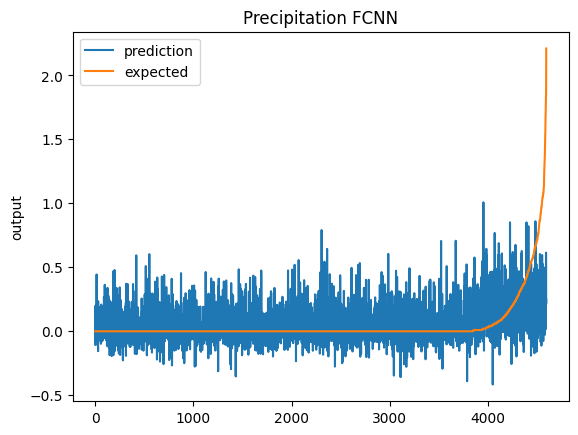

Final score (RMSE): 0.20244848021617337


In [15]:
#Ian Vachuska
#Make prediction
pred = model_fcnn.predict(fcnn_test)
df_y = pd.DataFrame(ya_test, columns=['actual'])
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)
#result[0:10]

#Plot chart
plt.title(f"{output_layer} FCNN")
chart_regression(pred.flatten(),y_test, sort=True)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

In [16]:
#Ian Vachuska
#model_fcnn.save("network_RMSE_{}.keras".format(score.round()))

# **CNN**

In [17]:
#Ian Vachuska
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), padding='same', input_shape = cnn_train.shape[1:]))
model_cnn.add(Activation('relu'))
#model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation = 'relu'))
#model_cnn.add(Activation('relu'))
model_cnn.add(Dense(50, activation = 'relu'))
model_cnn.add(Dense(1))

sgd_cnn = optimizers.SGD(learning_rate=.01, momentum=0.9, nesterov=True)
adam_cnn = optimizers.Adam(learning_rate=.0001, beta_1=0.9, beta_2=0.999, epsilon=.1, amsgrad=False)
monitor_cnn = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

model_cnn.compile(loss='mean_squared_error', optimizer = adam_cnn)
model_cnn.fit(cnn_train, y_train, validation_data=(cnn_test,y_test),
               batch_size= 32, callbacks=[monitor_cnn], verbose=2, epochs=1000)

Epoch 1/1000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


335/335 - 7s - 20ms/step - loss: 0.0452 - val_loss: 0.0340
Epoch 2/1000
335/335 - 1s - 2ms/step - loss: 0.0438 - val_loss: 0.0337
Epoch 3/1000
335/335 - 1s - 2ms/step - loss: 0.0433 - val_loss: 0.0335
Epoch 4/1000
335/335 - 1s - 2ms/step - loss: 0.0429 - val_loss: 0.0333
Epoch 4: early stopping


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


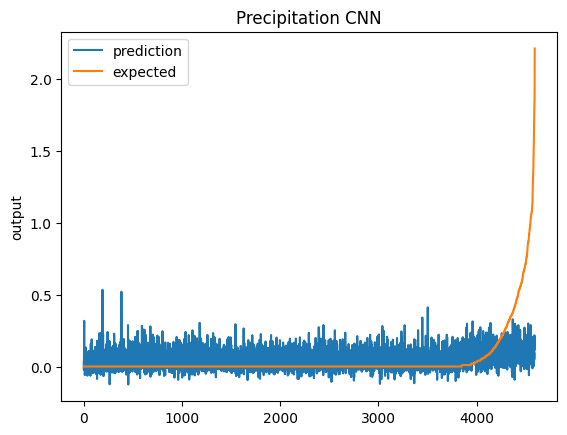

Final score (RMSE): 0.1824466022260014


In [18]:
#Ian Vachuska
#Make prediction
pred_cnn = model_cnn.predict(cnn_test)
df_y_cnn = pd.DataFrame(y_test, columns=['actual'])
df_pred_cnn = pd.DataFrame(pred_cnn, columns=['predicted'])
result_cnn = pd.concat([df_y_cnn, df_pred_cnn],axis=1)
#result_cnn[0:10]

#Plot chart
plt.title(f"{output_layer} CNN")
chart_regression(pred_cnn.flatten(),y_test, sort=True)

# Measure RMSE error.  RMSE is common for regression.
score_cnn = np.sqrt(metrics.mean_squared_error(pred_cnn,y_test))
print("Final score (RMSE): {}".format(score_cnn))

# **RNN**

In [19]:
#Brandon Kmiec

rnn_bidirectional = Sequential()

rnn_bidirectional.add(Bidirectional(LSTM(256, dropout=0.1, 
                                         recurrent_dropout=0.1, 
                                         input_shape=(5, SEQUENCE_SIZE))))
rnn_bidirectional.add(Dense(128))
rnn_bidirectional.add(Dense(64))
rnn_bidirectional.add(Dense(32))
rnn_bidirectional.add(Dense(16))
rnn_bidirectional.add(Dense(8))
rnn_bidirectional.add(Dense(4))
rnn_bidirectional.add(Dense(2))
rnn_bidirectional.add(Dense(1))

rnn_bidirectional.compile(loss='mean_squared_error', optimizer='adam')

monitor_rnn_bidirectional = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                                          patience=3, verbose=1, mode='auto')

rnn_bidirectional.fit(rnn_train, y_train, 
                      validation_data=(rnn_test, y_test), 
                      callbacks=[monitor_rnn_bidirectional], 
                      verbose=2, epochs=1000)

Epoch 1/1000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


335/335 - 15s - 43ms/step - loss: 0.0474 - val_loss: 0.0323
Epoch 2/1000
335/335 - 6s - 19ms/step - loss: 0.0411 - val_loss: 0.0310
Epoch 3/1000
335/335 - 6s - 19ms/step - loss: 0.0400 - val_loss: 0.0323
Epoch 4/1000
335/335 - 6s - 19ms/step - loss: 0.0393 - val_loss: 0.0303
Epoch 5/1000
335/335 - 7s - 19ms/step - loss: 0.0384 - val_loss: 0.0301
Epoch 5: early stopping


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


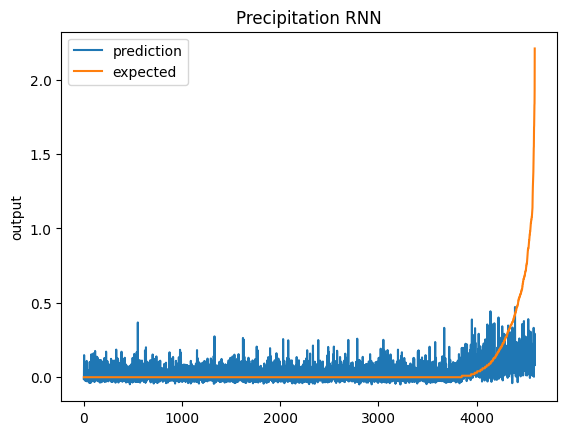

Final score (RMSE): 0.1734362012275215


In [20]:
#Brandon Kmiec

#Make prediction
pred_rnn = rnn_bidirectional.predict(rnn_test)
df_y_rnn = pd.DataFrame(y_test, columns=['actual'])
df_pred_rnn = pd.DataFrame(pred_rnn, columns=['predicted'])
result_rnn = pd.concat([df_y_rnn, df_pred_rnn],axis=1)

#Plot chart
plt.title(f"{output_layer} RNN")
chart_regression(pred_rnn.flatten(),y_test, sort=True)

# Measure RMSE error.  RMSE is common for regression.
score_rnn = np.sqrt(metrics.mean_squared_error(pred_rnn,y_test))
print("Final score (RMSE): {}".format(score_rnn))